# Terrence Thesis - Case Study

### Import Statements

In [1]:
import flopy
import flopy.modflow as mf
import flopy.utils as fu
import flopy.utils.binaryfile as bf
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import platform
import shutil
import sys

%matplotlib inline

### Setup folder where modflow-files are located

In [2]:
workspace = os.path.join('mf-data')

In [3]:
if os.path.exists(workspace):
    shutil.rmtree(workspace)

if not os.path.exists(workspace):
    os.makedirs(workspace)

### Print versions

In [4]:
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.6.3 (v3.6.3:2c5fed8, Oct  3 2017, 18:11:49) [MSC v.1900 64 bit (AMD64)]
numpy version: 1.14.3
matplotlib version: 2.1.1
flopy version: 3.2.9


### Setup MF-Package

In [5]:
modelname = 'model'
exe_name = 'mf2005'

if platform.system() == 'Windows':
    exe_name += '.exe'

In [6]:
tm = mf.Modflow(modelname=modelname, exe_name=exe_name, version='mf2005', model_ws=workspace)

### Setup Discretization Package

In [7]:
nrow = 1
ncol = 95
nlay = 10

Lx = 950
Ly = 25

botm = np.ones ( (nlay, nrow, ncol), dtype=np.int32 )
top = 33 * np.ones ( (nrow, ncol), dtype=np.int32 )

# Range does not include upper bound !!!
for i in range ( 30, 33):
    top[ :, i ] = 31
for i in range ( 47, 48 ):
    top[ :, i ] = 28
for i in range ( 50, 65):
    top[ :, i ] = 32

# N1 layer
botm[ 0, :, : ] = 28
for i in range ( 47, 49):
    botm[ 0, :, i ] = 28
# N2 layer46 
for i in range ( 0, 46):
    botm[ 1, :, i ] = 24
for i in range ( 46, 48 ):
    botm[ 1, :, i ] = 25
for i in range ( 48, 67 ):
    botm[ 1, :, i ] = 26
for i in range ( 67, ncol ):
    botm[ 1, :, i ] = 25
# N3 layer
for i in range ( 0, 33 ):
    botm[ 2, :, i ] = 20
for i in range ( 33, 46 ):
    botm[ 2, :, i ] = 21.5
for i in range ( 46, 48 ):
    botm[ 2, :, i ] = 24
for i in range ( 48, ncol ):
    botm[ 2, :, i ] = 24.5
# N4 layer
for i in range ( 0, 47 ):
    botm[ 3, :, i ] = 17
for i in range ( 47, 50 ):
    botm[ 3, :, i ] = 16
for i in range ( 50, 60 ):
    botm[ 3, :, i ] = 15
for i in range ( 60, ncol ):
    botm[ 3, :, i ] = 20
# N5 layer
for i in range ( 0, 50 ):
    botm[ 4, :, i ] = 15
for i in range ( 50, 60 ):
    botm[ 4, :, i ] = 14
for i in range ( 60, ncol ):
    botm[ 4, :, i ] = 16
# N6 layer
for i in range ( 0, 60 ):
    botm[ 5, :, i ] = 13
for i in range ( 60, ncol ):
    botm[ 5, :, i ] = 15
# 7 layer
botm[ 6, :, : ] = 10
# 8 layer
botm[ 7, :, : ] = 9
# 9 layer
botm[ 8, :, : ] = -12.5
# 10 layer
botm[ 9, :, : ] = -30

delr = Lx / ncol
delc = Ly / nrow
nper = 3521

perlen = 1
steady = np.full ( nper, False, dtype=bool )
steady[ 0 ] = True

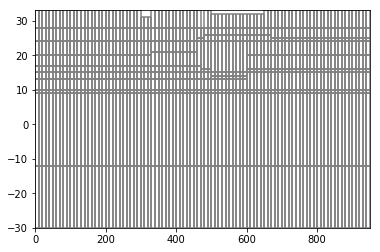

In [8]:
dis = mf.ModflowDis(
    tm, 
    nlay=nlay,
    nrow=nrow, 
    ncol=ncol, 
    delr=delr, 
    delc=delc, 
    top=top, 
    botm=botm, 
    nper=nper, 
    steady=steady
)

modelxsect= flopy.plot.ModelCrossSection(model=tm, line={'Row':0})
linecollection= modelxsect.plot_grid()

### Setup Basic-Package

Specify boundary conditions and starting heads.

We can set one value for all cells.

In [9]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

for i in range ( 1, nlay ):
    ibound[ i, :, 0 ] = -1
    ibound[ i, :, -1 ] = -1

for k in range ( 47, 49 ):
    ibound[ 0, :, k ] = 0

strt = np.ones ( (nlay, nrow, ncol), dtype=np.int32 ) * 28
strt[ 1, :, 1 ] = 28
strt[ 1, :, -1 ] = 28

for i in range ( 30, 33 ):
    strt[ 0, :, i ] = 30
for j in range ( 50, 65 ):
    strt[ 0, :, j ] = 30
    
bas = mf.ModflowBas(tm, ibound=ibound, strt=strt)

#bas.plot()

### Setup Constant Head Boundaries

In [10]:
csv = pd.read_csv('SPA101.csv', delimiter=',')
chd_values = csv.iloc[ :, 2 ].values

#chd for each cell
#[lay, row, col, shead, ehead]
spchd = {}
spchd[0] = [
    [1, 0, 0, 28, 28 ], 
    [1, 0, ncol-1, 28, 28]
]

for layer in range (2, nlay):
    spchd[0].append ([layer, 0, 0, 28, 28 ])

for stress_period in range ( 1, nper ):
    spchd[stress_period] = [[1, 0, 0, chd_values[stress_period - 1], chd_values[stress_period]]]
    for layer in range (2, nlay):
        spchd[stress_period].append ([layer, 0, 0, chd_values[stress_period-1], chd_values[stress_period]])

chd = mf.ModflowChd(tm, stress_period_data=spchd)
#chd.plot()

### Setup General Head Boundaries

In [11]:
sp = {}
sp[0] = []
bas12_data = pd.read_csv ( 'Basin1&2.csv', delimiter=',' ).iloc[ :, 1 ].values
bas3_data = pd.read_csv ( 'Basin3.csv', delimiter=',' ).iloc[ :, 1 ].values

for col in range ( 30, 33 ):
    sp[ 0 ].append ( [ 0, 0, col, 31, 1450 ] )
    
for col in range ( 50, 65 ):
    sp[ 0 ].append ( [ 0, 0, col, 31, 1500 ] )
    
for stress_period in range ( 1,  nper ):
    sp[ stress_period ] = [ ]
    for col in range ( 30, 33 ):
        sp[ stress_period ].append ( [ 0, 0, col, 29 + 2.5*bas3_data[ stress_period - 1 ], 1800 ] )
    for col in range ( 50, 65 ):
        sp[ stress_period ].append ( [ 0, 0, col, 28.5 + 5*bas12_data[ stress_period - 1 ], 2000 ] )

ghb = mf.ModflowGhb (tm, stress_period_data=sp)
#ghb.plot()

### Setup Wells

In [12]:
# Pumping Well
wel_data = pd.read_csv('Pumping_well.csv', delimiter=',').iloc[:, -2].values

spwell = {}
spwell[0] = [8, 0, 41, 0]
for i in range(1, nper):
    spwell[i] = [8, 0, 41, -wel_data[i-1]]

wel = mf.ModflowWel(tm, stress_period_data=spwell, ipakcb=53)

#wel.plot()

### Setup Soil properties and Flow-Package

In [13]:
k1 = 2   # fine sand 1.728-7.776
k2 = 34  # middle sand 7.776-34.56
k3 = 41  # stone 34.56-103.68
k4 = 1   # clay
k5 = 45  # middle sand2
k6 = 6   # fine sand 1.728-7.776

# Set default hk-value value to k2
hk = np.ones((nlay, nrow, ncol)) * k2

# N1 layer
hk[0, :, :] = k1  # fine sand

# N2 layer
hk[1, :, :] = k2  # middle sand

# N3 layer
for i in range( 30, 60 ):
    hk[2, :, i] = k3  # sand & stone
for i in range( 55, 67 ):
    hk[2, :, i] = k4  # clay

#  N4 layer
hk[3, :, :] = k5  # middle sand2

# N5 layer
for i in range( 30, 44 ):
    hk[4, :, i] = k3  # sand & stone
for i in range( 44, 48 ):
    hk[4, :, i] = k4  # clay
for i in range( 48, 60 ):
    hk[4, :, i] = k3  # sand & stone
for i in range( 60, 65 ):
    hk[4, :, i] = k4  # clay

# N6 layer
hk[5, :, :] = k3
for i in range(36, 50 ):
    hk[5, :, i] = k6  # fine sand
for i in range( 50, 60 ):
    hk[5, :, i] = k3  # sand & stone
for i in range( 60, 65 ):
    hk[5, :, i] = k4  # clay

# 7 layer
hk[6, :, :] = k5  # middle sand2

# 8 layer
hk[7, :, :] = k5
for i in range(36 , 50 ):
    hk[7, :, i] = k6  # fine sand

# 9 layer
hk[8, :, :] = k5  # middle sand2

# 10 layer
hk[9, :, :] = k5  # middle sand2

# vertical HK
vk1 = 4
vk2 = 15
vk3 = 20
vk4 = 0.5
vk5 = 20
vk6 = 3

vka = np.ones((nlay, nrow, ncol), dtype=int) * vk3

# N1 layer
vka[0, :, :] = vk1  # fine sand

# N2 layer
vka[1, :, :] = vk2  # middle sand

# N3 layer
vka[2, :, :] = vk3
for i in range( 30, 55 ):
    vka[2, :, i] = vk3  # sand & stone
for i in range( 55, 67 ):
    vka[2, :, i] = vk4  # clay

# N4 layer
vka[3, :, :] = vk5  # middle sand2

# N5 layer
for i in range( 30, 44 ):
    vka[4, :, i] = vk3  # sand & stone
for i in range( 44, 48 ):
    vka[4, :, i] = vk4  # clay
for i in range( 48, 60 ):
    vka[4, :, i] = vk3  # sand & stone
for i in range( 60, 65 ):
    vka[4, :, i] = vk4  # clay

# N6 layer
vka[5, :, :] = vk3
for i in range( 36, 50 ):
    vka[5, :, i] = vk6  # fine sand
for i in range( 50, 60 ):
    vka[5, :, i] = vk3  # sand & stone
for i in range( 60, 65 ):
    vka[5, :, i] = vk4  # clay

# N7 layer
vka[6, :, :] = vk5  # middle sand2

# N8 layer
vka[7, :, :] = vk5
for i in range( 36, 50):
    vka[7, :, i] = vk6  # fine sand

# N9 layer
vka[8, :, :] = vk5  # middle sand2

# N10 layer
vka[9, :, :] = vk5  # middle sand2

laytyp = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
sy = 0.17
ss = 1e-4

lpf = mf.ModflowLpf(tm, laytyp=laytyp, hk=hk, layvka=0, vka=vka, sy=sy, ss=ss, ipakcb=53)

#lpf.plot()

### Head Observation Wells

### Setup Solver Package and Output-control with defaults

In [14]:
budgetfile = '{}.cbb'.format(modelname)
budget_filerecord = [budgetfile]

oc = mf.ModflowOc(tm, 
                   save_every=True,
                   save_types=['print head', 'print budget','print drawdown', 'save head', 'save budget','save drawdown'],
                   budget_filerecord=budget_filerecord,
                   compact=True
                  )

pcg = mf.ModflowPcg (tm, rclose=1e-1)

### Write Model input and run the model

In [15]:
tm.write_input()
success, buff = tm.run_model()

FloPy is using the following executable to run the model: C:\modflow\Packages\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/10/01 11:48:27

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     1    Gro

 Solving:  Stress period:   120    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:     1    Ground-Wa

 Solving:  Stress period:   229    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:     1    Ground-Wa

 Solving:  Stress period:   337    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:     1    Ground-Wa

 Solving:  Stress period:   443    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   444    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   445    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   446    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   447    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   448    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   449    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   450    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   451    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   452    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   453    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   454    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   455    Time step:     1    Ground-Wa

 Solving:  Stress period:   552    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   553    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   554    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   555    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   556    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   557    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   558    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   559    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   560    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   561    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   562    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   563    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   564    Time step:     1    Ground-Wa

 Solving:  Stress period:   675    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   676    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   677    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   678    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   679    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   680    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   681    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   682    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   683    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   684    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   685    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   686    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   687    Time step:     1    Ground-Wa

 Solving:  Stress period:   781    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   782    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   783    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   784    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   785    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   786    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   787    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   788    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   789    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   790    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   791    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   792    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   793    Time step:     1    Ground-Wa

 Solving:  Stress period:   895    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   896    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   897    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   898    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   899    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   900    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   901    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   902    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   903    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   904    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   905    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   906    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   907    Time step:     1    Ground-Wa

 Solving:  Stress period:  1002    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1003    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1004    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1005    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1006    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1007    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1008    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1009    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1010    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1011    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1012    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1013    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1014    Time step:     1    Ground-Wa

 Solving:  Stress period:  1111    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1112    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1113    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1114    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1115    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1116    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1117    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1118    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1119    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1120    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1121    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1122    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1123    Time step:     1    Ground-Wa

 Solving:  Stress period:  1217    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1218    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1219    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1220    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1221    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1222    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1223    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1224    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1225    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1226    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1227    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1228    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1229    Time step:     1    Ground-Wa

 Solving:  Stress period:  1325    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1326    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1327    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1328    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1329    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1330    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1331    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1332    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1333    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1334    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1335    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1336    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1337    Time step:     1    Ground-Wa

 Solving:  Stress period:  1433    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1434    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1435    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1436    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1437    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1438    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1439    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1440    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1441    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1442    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1443    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1444    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1445    Time step:     1    Ground-Wa

 Solving:  Stress period:  1555    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1556    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1557    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1558    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1559    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1560    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1561    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1562    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1563    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1564    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1565    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1566    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1567    Time step:     1    Ground-Wa

 Solving:  Stress period:  1675    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1676    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1677    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1678    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1679    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1680    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1681    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1682    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1683    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1684    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1685    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1686    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1687    Time step:     1    Ground-Wa

 Solving:  Stress period:  1793    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1794    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1795    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1796    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1797    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1798    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1799    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1800    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1801    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1802    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1803    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1804    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1805    Time step:     1    Ground-Wa

 Solving:  Stress period:  1914    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1915    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1916    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1917    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1918    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1919    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1920    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1921    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1922    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1923    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1924    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1925    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  1926    Time step:     1    Ground-Wa

 Solving:  Stress period:  2029    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2030    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2031    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2032    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2033    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2034    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2035    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2036    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2037    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2038    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2039    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2040    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2041    Time step:     1    Ground-Wa

 Solving:  Stress period:  2157    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2158    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2159    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2160    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2161    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2162    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2163    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2164    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2165    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2166    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2167    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2168    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2169    Time step:     1    Ground-Wa

 Solving:  Stress period:  2264    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2265    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2266    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2267    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2268    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2269    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2270    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2271    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2272    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2273    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2274    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2275    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2276    Time step:     1    Ground-Wa

 Solving:  Stress period:  2377    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2378    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2379    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2380    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2381    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2382    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2383    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2384    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2385    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2386    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2387    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2388    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2389    Time step:     1    Ground-Wa

 Solving:  Stress period:  2490    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2491    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2492    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2493    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2494    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2495    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2496    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2497    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2498    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2499    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2500    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2501    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2502    Time step:     1    Ground-Wa

 Solving:  Stress period:  2609    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2610    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2611    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2612    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2613    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2614    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2615    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2616    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2617    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2618    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2619    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2620    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2621    Time step:     1    Ground-Wa

 Solving:  Stress period:  2723    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2724    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2725    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2726    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2727    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2728    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2729    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2730    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2731    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2732    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2733    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2734    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2735    Time step:     1    Ground-Wa

 Solving:  Stress period:  2837    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2838    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2839    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2840    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2841    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2842    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2843    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2844    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2845    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2846    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2847    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2848    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2849    Time step:     1    Ground-Wa

 Solving:  Stress period:  2953    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2954    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2955    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2956    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2957    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2958    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2959    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2960    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2961    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2962    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2963    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2964    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  2965    Time step:     1    Ground-Wa

 Solving:  Stress period:  3059    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3060    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3061    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3062    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3063    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3064    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3065    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3066    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3067    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3068    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3069    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3070    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3071    Time step:     1    Ground-Wa

 Solving:  Stress period:  3171    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3172    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3173    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3174    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3175    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3176    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3177    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3178    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3179    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3180    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3181    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3182    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3183    Time step:     1    Ground-Wa

 Solving:  Stress period:  3277    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3278    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3279    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3280    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3281    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3282    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3283    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3284    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3285    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3286    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3287    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3288    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3289    Time step:     1    Ground-Wa

 Solving:  Stress period:  3385    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3386    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3387    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3388    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3389    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3390    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3391    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3392    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3393    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3394    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3395    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3396    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3397    Time step:     1    Ground-Wa

 Solving:  Stress period:  3504    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3505    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3506    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3507    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3508    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3509    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3510    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3511    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3512    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3513    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3514    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3515    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:  3516    Time step:     1    Ground-Wa

### Read Observations

In [16]:
headobj = bf.HeadFile(os.path.join(workspace, modelname + '.hds'))

#observation wells
#well 157
ts1 = headobj.get_ts ( idx=(1, 0, 56) )

# todo: implement HOB-Package